## OBJECTIVE :

### Classifying toxic comments

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import os
import sys
import ipdb
import numpy as np
import pandas as pd
import spacy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import sent_tokenize, word_tokenize

print("Numpy Version : ", np.__version__)
print("Pandas Version : ", pd.__version__)

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

print("Matplotlib Version : ", mpl.__version__)

Numpy Version :  1.18.1
Pandas Version :  1.0.1
Matplotlib Version :  3.1.3


In [3]:
# Initializing spacy model
nlp = spacy.load('en_core_web_md')

In [4]:
DATA_DIR = "../data/"
OBJECT_DIR = "../objects/"
LOG_DIR = "../logs/"

In [5]:
LUCKY_SEED = 42

In [8]:
RAW_DATA_DIR = os.path.join(DATA_DIR, "raw_data")
KAGGLE_RAW_DATA_DIR = os.path.join(RAW_DATA_DIR, "jigsaw-toxic-comment-classification-challenge")

In [7]:
STOPWORDS = nlp.Defaults.stop_words.union(STOPWORDS)
KEEPWORDS = ['up', 'down', 'no', 'not', 'nothing', 'none', 'neither', 'never', 'except', 'below', 'bottom', 'without', 'serious', \
            'really', 'above', 'against', 'cannot', 'least', 'less', 'more', 'most', 'must', 'top', 'well']
# for word in KEEPWORDS:
#     STOPWORDS.remove(word)
STOPWORDS = list(STOPWORDS)
DATE_STOPWORDS = ['january', 'february', 'march', 'april', 'may', 'june', \
                  'july', 'august', 'september', 'october', 'november', 'december', \
                 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', \
                 'today', 'tomorrow', 'yesterday', 'year', 'month', 'date', 'day']
NUM_STOPWORDS = ['hundred', 'hundreds', 'thousand', 'thousands', 'million', 'millions', 'billion', 'billions']
REL_STOPWORDS = ['brother', 'sister', 'son', 'daughter', 'father', 'mother', 'uncle', 'aunt', 'aunty', 'wife', \
                 'husband', 'cousin', 'nephew', 'niece', 'child', 'dad', 'mom', 'papa', 'mummy', 'bro', 'sis', \
                 'grandfather', 'grandmother', 'granny', 'grandpa', 'grandma', 'children', 'boy', 'boys', 'guy', \
                 'guys', 'girl', 'girls', 'man', 'men', 'woman', 'women']
DIR_STOPWORDS = ['north', 'south', 'east', 'west']
STOPWORDS += DATE_STOPWORDS + NUM_STOPWORDS + REL_STOPWORDS + DIR_STOPWORDS
STOPWORDS = set(STOPWORDS)
print(len(STOPWORDS))

459


In [9]:
# Read train data
train_data = pd.read_csv(os.path.join(KAGGLE_RAW_DATA_DIR, "train.csv"))

In [10]:
train_data.shape

(159571, 8)

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [12]:
train_data.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [15]:
# Read test data
test_data_kaggle = pd.read_csv(os.path.join(KAGGLE_RAW_DATA_DIR, "test.csv"))
print("Shape of kaggle test data : {}".format(test_data_kaggle.shape))
print()
print("Features in kaggle test data : {}".format(test_data_kaggle.columns.values))
print()
print("Kaggle Test Dataframe Information : ")
print(test_data_kaggle.info())

Shape of kaggle test data : (153164, 2)

Features in kaggle test data : ['id' 'comment_text']

Kaggle Test Dataframe Information : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB
None


#### Analysis of train data

In [16]:
train_data["toxic"].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [17]:
train_data["severe_toxic"].value_counts()

0    157976
1      1595
Name: severe_toxic, dtype: int64

In [18]:
train_data["obscene"].value_counts()

0    151122
1      8449
Name: obscene, dtype: int64

In [19]:
train_data["threat"].value_counts()

0    159093
1       478
Name: threat, dtype: int64

In [20]:
train_data["insult"].value_counts()

0    151694
1      7877
Name: insult, dtype: int64

In [30]:
train_data["identity_hate"].value_counts()

0    158166
1      1405
Name: identity_hate, dtype: int64

In [23]:
train_data.drop_duplicates(subset="comment_text").shape, train_data.shape, train_data.drop_duplicates().shape

((159571, 8), (159571, 8), (159571, 8))

In [24]:
CLASSES = ("toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate")

In [31]:
target_df = pd.DataFrame(columns=["class", "count"])

In [32]:
for i in range(len(CLASSES)):
    target_df.loc[i, "class"] = CLASSES[i]
    target_df.loc[i, "count"] = train_data[CLASSES[i]].value_counts()[1]

In [33]:
target_df

class  count
0          toxic  15294
1   severe_toxic   1595
2        obscene   8449
3         threat    478
4         insult   7877
5  identity_hate   1405

In [36]:
target_df["class"].values, target_df["count"].values

(array(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
        'identity_hate'], dtype=object),
 array([15294, 1595, 8449, 478, 7877, 1405], dtype=object))

Different types of comments and their counts : 


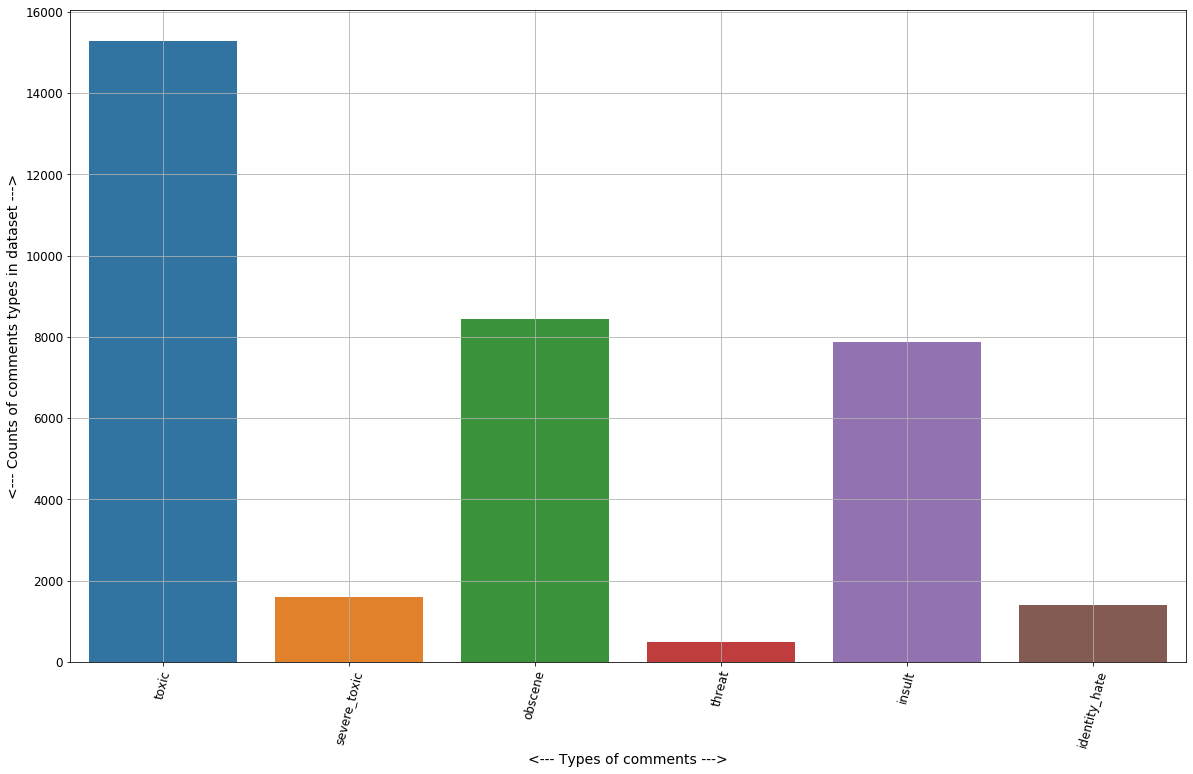

In [35]:
print('Different types of comments and their counts : ')
fig_dims = (20, 12)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(target_df["class"].values, target_df["count"].values)
plt.xticks(rotation=75)
plt.grid()
plt.xlabel('<--- Types of comments --->')
plt.ylabel('<--- Counts of comments types in dataset --->')
plt.show()

In [37]:
train_data["lcased_text"] = train_data["comment_text"].map(lambda x:x.lower())

In [38]:
def create_wordcloud(sentences, label):
    print("Target Type : ", label)
    fig_dims = (20, 12)
    text = ' '.join(sentences) 
    wordcloud = WordCloud(stopwords=STOPWORDS, max_words=200, background_color="white").generate(text)
    fig, ax = plt.subplots(figsize=fig_dims)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
def get_word_count(text):
    word_count = 0
    sentences = sent_tokenize(text)
    for sen in sentences:
        word_count += len(word_tokenize(sen))
    return word_count

Target Type :  toxic


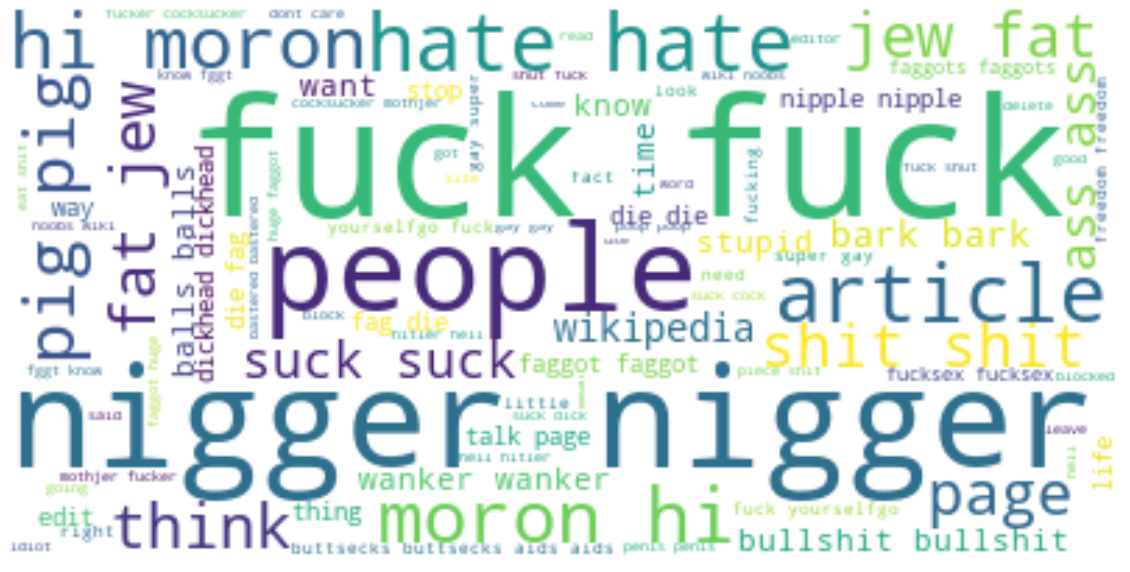

Target Type :  severe_toxic


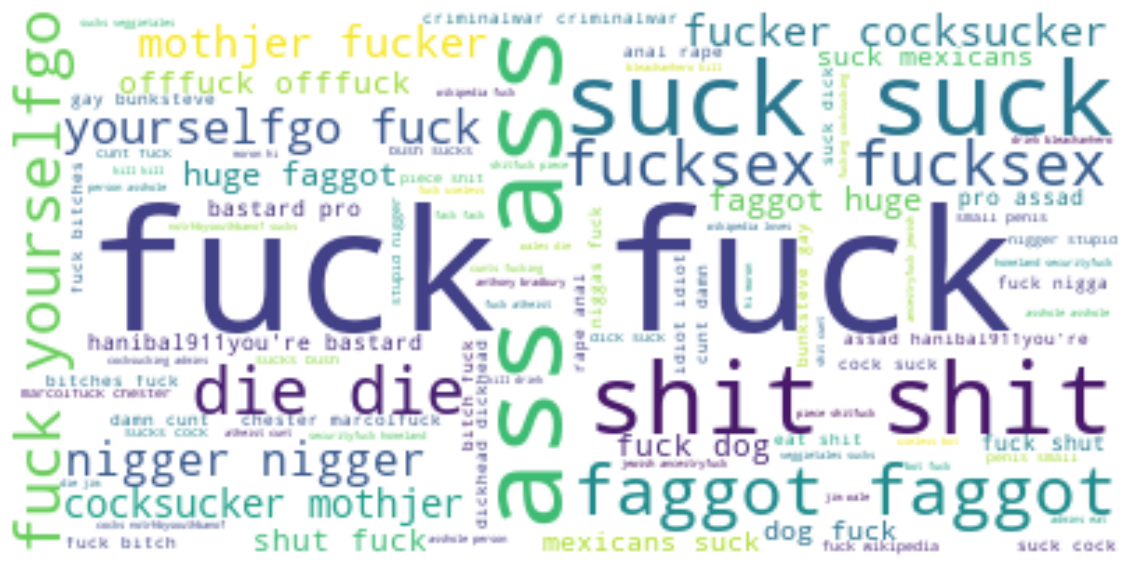

Target Type :  obscene


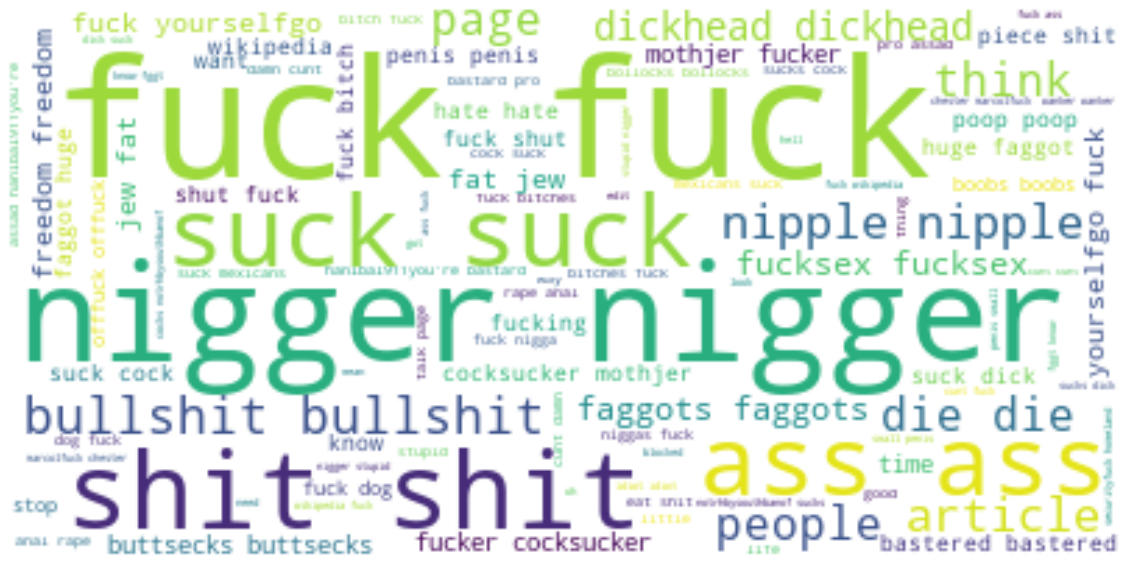

Target Type :  threat


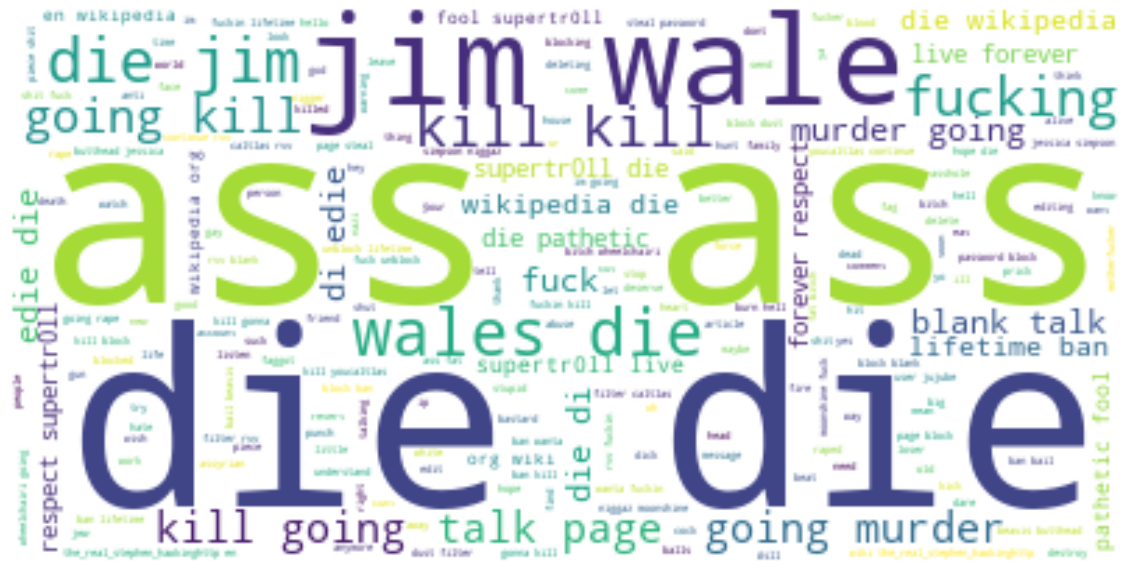

Target Type :  insult


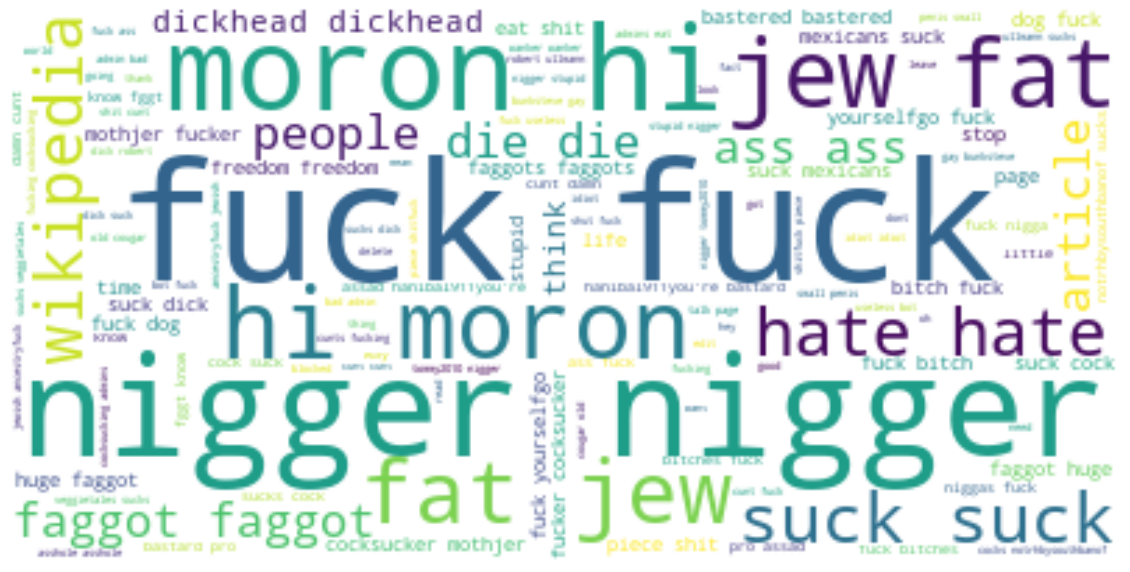

Target Type :  identity_hate


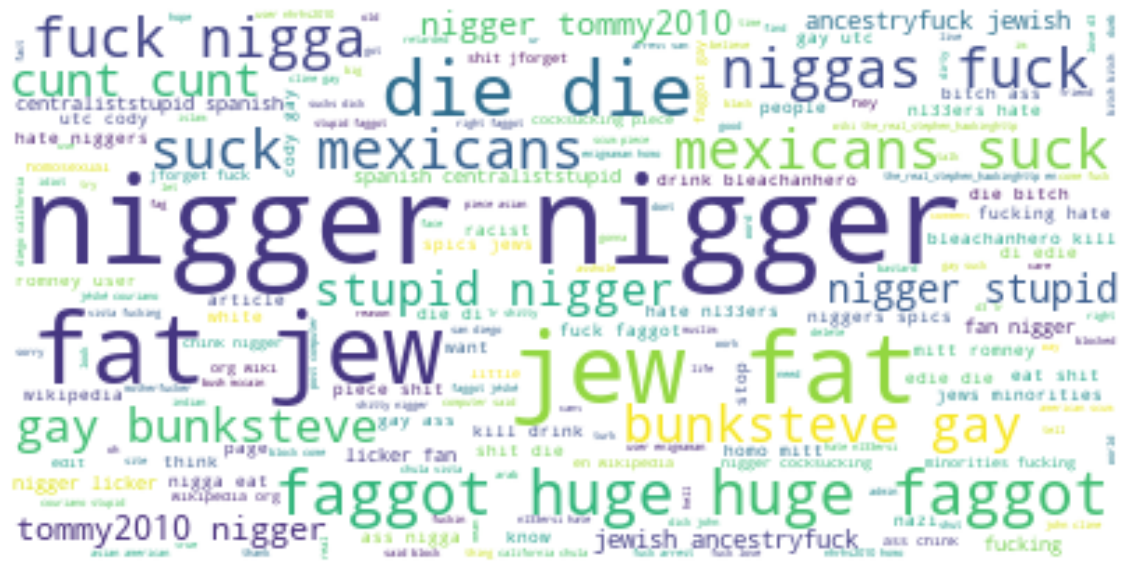

In [40]:
for c in CLASSES:
    create_wordcloud(train_data.loc[train_data[c]==1, "lcased_text"].values, c)

Target Type :  not toxic


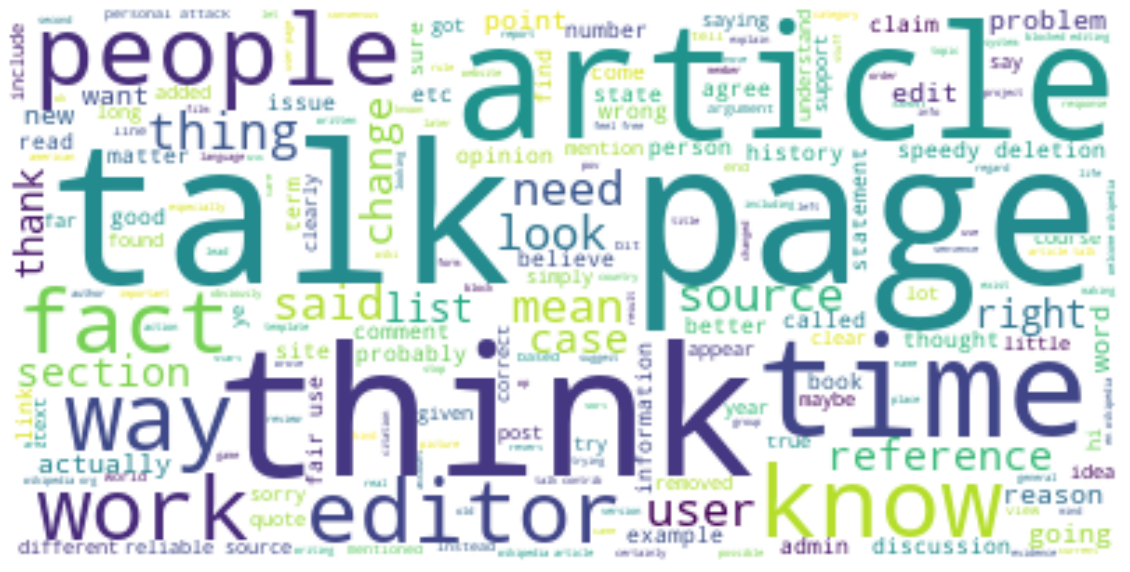

Target Type :  not severe_toxic


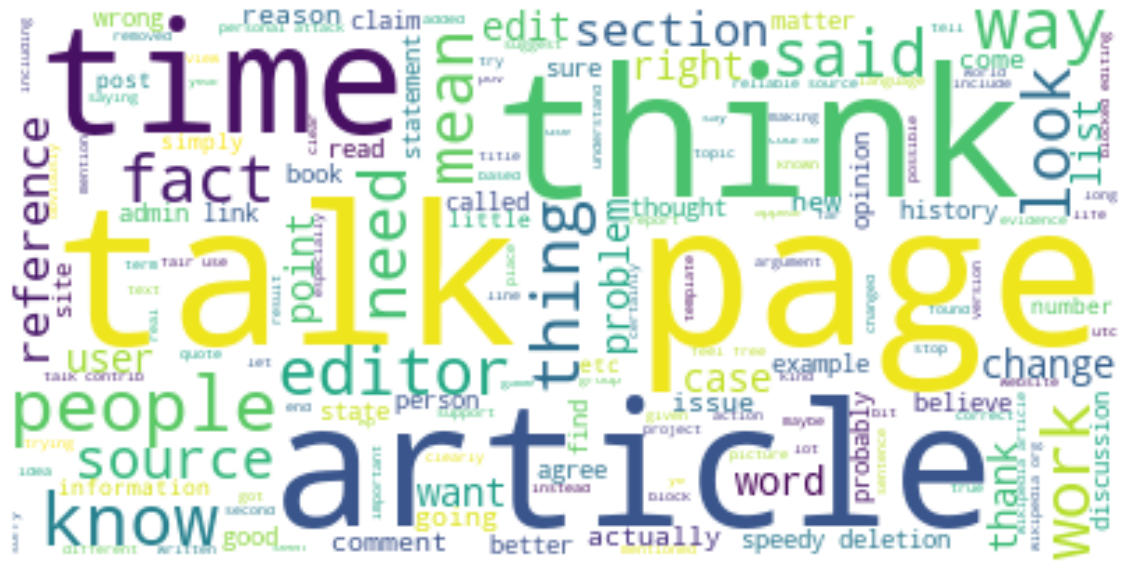

Target Type :  not obscene


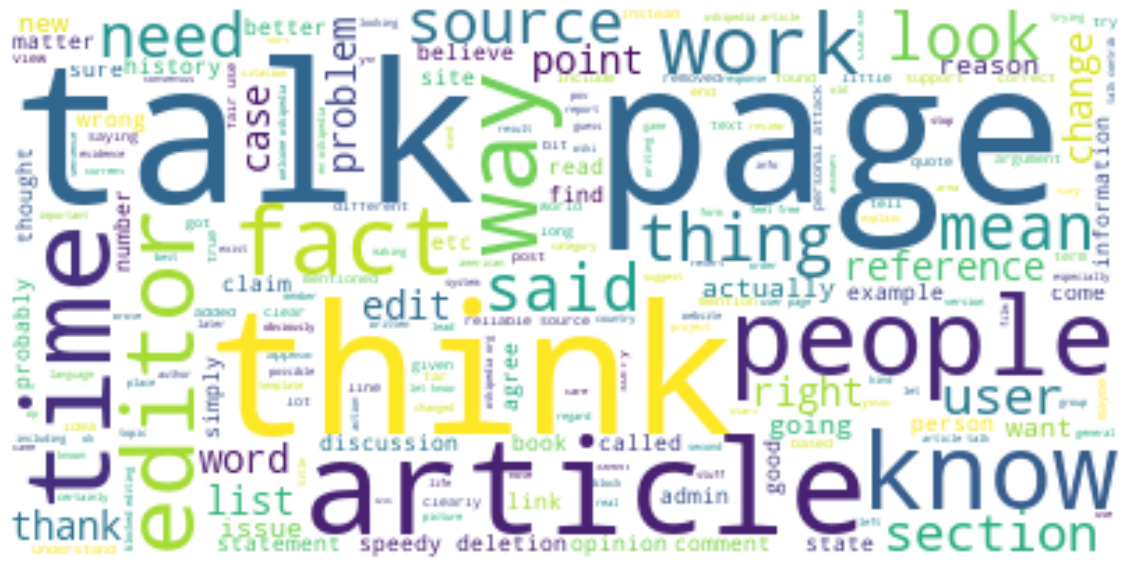

Target Type :  not threat


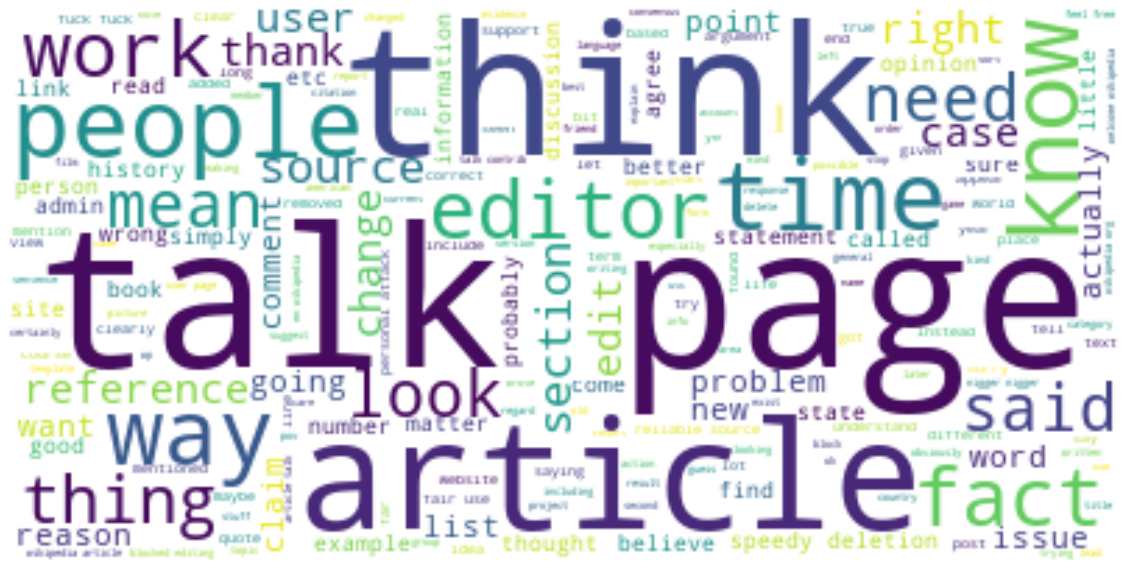

Target Type :  not insult


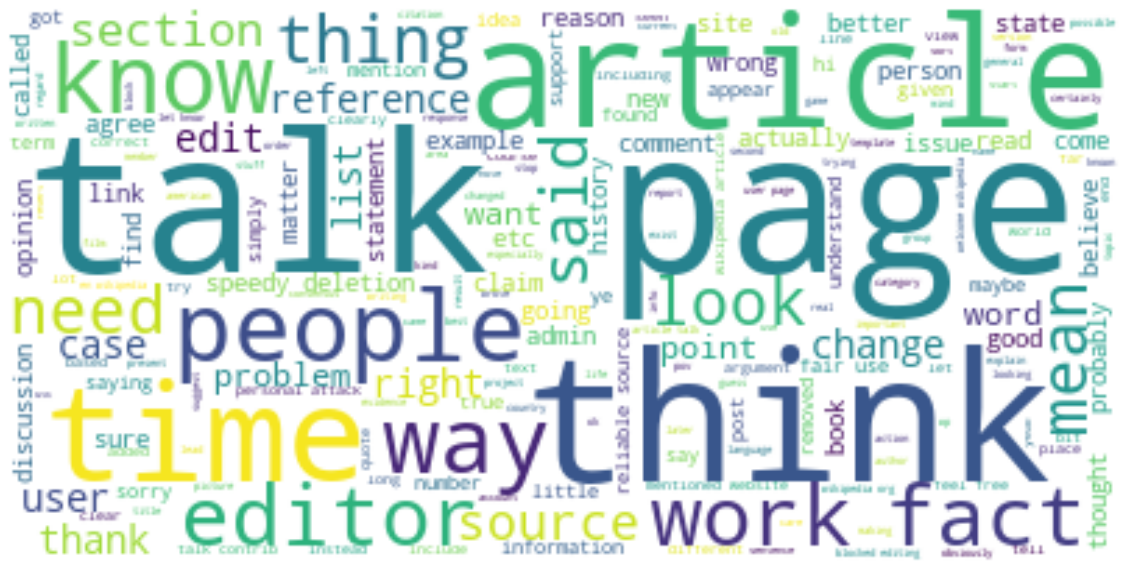

Target Type :  not identity_hate


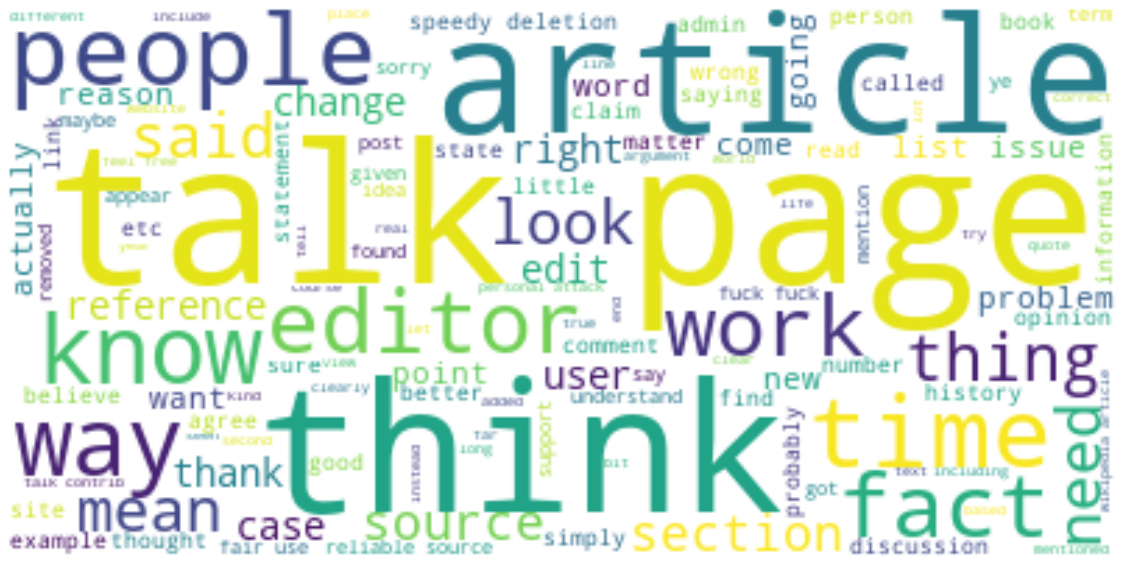

In [41]:
for c in CLASSES:
    create_wordcloud(train_data.loc[train_data[c]==0, "lcased_text"].values, "not " + c)